In [1]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---------------------------------
# 1) 데이터 로드
# ---------------------------------

df = pd.read_csv('/content/drive/MyDrive/ml-programming-lab/week9/TSLA.csv')

In [2]:
# 날짜 순으로 정렬
df = df.sort_values('Date')

# 종가만 추출
data = df['Close'].values.reshape(-1, 1)

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2951,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2952,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400


In [4]:
# -----------------------------
# 2) 정규화 (0~1)
# -----------------------------

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [5]:
# -----------------------------
# 3) 시퀀스 생성 함수
#    최근 window일 → 다음 날 종가 예측
# -----------------------------

def make_sequence(data, window):
    X_list, y_list = [], []
    for i in range(len(data) - window):
        X_list.append(data[i:i+window])
        y_list.append(data[i+window])
    return np.array(X_list), np.array(y_list)

window = 60  # 최근 60일 보고 다음날 예측
X, y = make_sequence(data, window)

In [6]:
# -----------------------------
# 4) 훈련 / 테스트 분리 (시계열이기 때문에 섞이면 X)
# -----------------------------

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

X_train: (2316, 60, 1)
X_test : (580, 60, 1)


In [7]:
# -----------------------------
# 5) RNN(SimpleRNN)
# -----------------------------

model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window, 1)),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

model_rnn.compile(optimizer='adam', loss='mse')

history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    verbose=0
)

In [8]:
# -----------------------------
# 6) LSTM
# -----------------------------

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window, 1)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    verbose=0
)

In [9]:
# ---------------------------------
# 7) 예측
# ---------------------------------

# train 구간 예측
pred_train_rnn  = model_rnn.predict(X_train)
pred_train_lstm = model_lstm.predict(X_train)

# test 구간 예측
pred_test_rnn  = model_rnn.predict(X_test)
pred_test_lstm = model_lstm.predict(X_test)

73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [10]:
# ---------------------------------
# 8) MSE 계산
# ---------------------------------

# RNN MSE
mse_train_rnn  = mean_squared_error(y_train,  pred_train_rnn)
mse_test_rnn   = mean_squared_error(y_test,   pred_test_rnn)

# LSTM MSE
mse_train_lstm = mean_squared_error(y_train,  pred_train_lstm)
mse_test_lstm  = mean_squared_error(y_test,   pred_test_lstm)

print("RNN  Train MSE:", mse_train_rnn)
print("RNN  Test  MSE:", mse_test_rnn)
print("LSTM Train MSE:", mse_train_lstm)
print("LSTM Test  MSE:", mse_test_lstm)

RNN  Train MSE: 1.1182255865798644e-06
RNN  Test  MSE: 0.0010607985094518639
LSTM Train MSE: 1.189221363042634e-06
LSTM Test  MSE: 0.001892703882809018


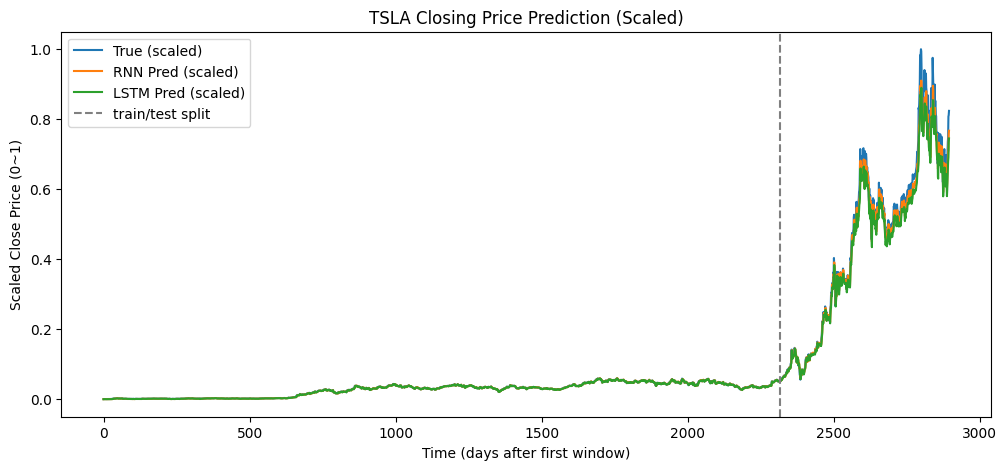

In [11]:
# ---------------------------------
# 9) 그래프 시각화
# ---------------------------------

# 실제 전체 y (train+test) 연결
y_all = np.vstack([y_train, y_test])

# 모델 예측도 train+test 순서대로 이어붙이기
pred_all_rnn  = np.vstack([pred_train_rnn,  pred_test_rnn])
pred_all_lstm = np.vstack([pred_train_lstm, pred_test_lstm])

plt.figure(figsize=(12,5))
plt.plot(y_all, label='True (scaled)')
plt.plot(pred_all_rnn, label='RNN Pred (scaled)')
plt.plot(pred_all_lstm, label='LSTM Pred (scaled)')
plt.axvline(x=len(y_train)-1, linestyle='--', color='gray', label='train/test split')
plt.title('TSLA Closing Price Prediction (Scaled)')
plt.xlabel('Time (days after first window)')
plt.ylabel('Scaled Close Price (0~1)')
plt.legend()
plt.show()

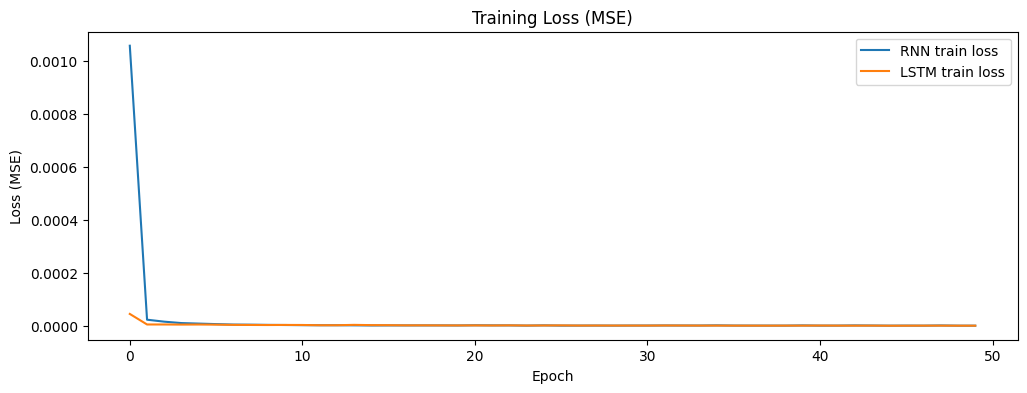

In [12]:
# ---------------------------------
# 10) loss 곡선 비교
# ---------------------------------

plt.figure(figsize=(12,4))
plt.plot(history_rnn.history['loss'],  label='RNN train loss')
plt.plot(history_lstm.history['loss'], label='LSTM train loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()